In [1]:
import wfdb
import csv
import pandas as pd
import numpy as np
import os

In [2]:
import os
import csv
import pandas as pd
import wfdb  # Make sure wfdb is installed

output_dir = "data_creation"
os.makedirs(output_dir, exist_ok=True)

# Patient numbers
patient_numbers = [
    "100", "101", "102", "103", "104", "105", "106", "107", "108", "109",
    "111", "112", "113", "114", "115", "116", "117", "118", "119", "121",
    "122", "123", "124", "200", "201", "202", "203", "205", "207", "208",
    "209", "210", "212", "213", "214", "215", "217", "219", "220", "221",
    "222", "223", "228", "230", "231", "232", "233", "234"
]

# N = normal 
# S = supra-ventricular premature
# V = ventricular escape
# F = fusion of ventricular and normal
# Q = unclassified heartbeats
symbol_to_category = {
    'N': 'N', '.': 'N', 'L': 'N', 'R': 'N', 'e': 'N', 'j': 'N',
    'a': 'S', 'A': 'S', 'J': 'S', 'S': 'S',
    'V': 'V', 'E': 'V',
    'F': 'F',
    '/': 'Q', 'f': 'Q', 'Q': 'Q'
}

for patient_number in patient_numbers:
    try:
        # ECG data
        path_to_record = f"mit-database/{patient_number}"
        patient_record = wfdb.rdrecord(path_to_record)
        leads = patient_record.sig_name
        ecg_data = patient_record.p_signal

        # ECG CSV
        ecg_filename = f"{output_dir}/{patient_number}_ECG.csv"
        with open(ecg_filename, "w", newline='') as outfile:
            out_csv = csv.writer(outfile)
            out_csv.writerow(leads)
            for row in ecg_data:
                out_csv.writerow(row)

        # Annotations data
        annotation = wfdb.rdann(path_to_record, 'atr')
        symbols = annotation.symbol
        annotations = annotation.sample

        # Filter out symbols not in symbol_to_category
        filtered_symbols_annotations = [(sym, ann) for sym, ann in zip(symbols, annotations) if sym in symbol_to_category]
        categories = [symbol_to_category[sym] for sym, ann in filtered_symbols_annotations]
        annotations_filtered = [ann for sym, ann in filtered_symbols_annotations]

        df_annotations = pd.DataFrame({'Category': categories, 'Annotation': annotations_filtered})

        # Annotations CSV
        annotations_filename = f"{output_dir}/{patient_number}_Annotations.csv"
        df_annotations.to_csv(annotations_filename, index=False)

    except Exception as e:
        print(f"Failed to process: {patient_number}: {e}")

print("Done")

Done


In [3]:
import os
import pandas as pd
import numpy as np


def process_patient_data(patient_number, data_creation_dir="data_creation"):
    ecg_file_path = os.path.join(data_creation_dir, f"{patient_number}_ECG.csv")
    annotations_file_path = os.path.join(data_creation_dir, f"{patient_number}_Annotations.csv")
    
    patient_X = []
    patient_Y = []
    
    try:
        ecg_df = pd.read_csv(ecg_file_path)
        annotations_df = pd.read_csv(annotations_file_path)
    except FileNotFoundError:
        print(f"Files for patient {patient_number} not found. Skipping...")
        return [], []
    
    first_column_name = ecg_df.columns[0]
    second_column_name = ecg_df.columns[1] if len(ecg_df.columns) > 1 else None

    sampling_rate = 360  # Hz
    total_window_size_seconds = 1  # Total window size in seconds
    total_window_size_samples = total_window_size_seconds * sampling_rate

    for _, row in annotations_df.iterrows():
        annotation_point = row['Annotation']
        category = row['Category']
        
        # Randomly determine the window split around the annotation point
        before_seconds = np.random.uniform(0, total_window_size_seconds)
        after_seconds = total_window_size_seconds - before_seconds
        before_samples = int(before_seconds * sampling_rate)
        after_samples = int(after_seconds * sampling_rate)
        
        start_point = max(0, annotation_point - before_samples)
        end_point = start_point + total_window_size_samples  # Ensure the window is of the exact expected size
        
        # Adjust the end point if it exceeds the length of the data
        if end_point > len(ecg_df):
            end_point = len(ecg_df)
            start_point = max(0, end_point - total_window_size_samples)  # Adjust start point accordingly
        
        # Process data from the first column
        window_data_first_column = ecg_df.iloc[start_point:end_point][first_column_name].to_numpy()
        
        patient_X.append(window_data_first_column)
        patient_Y.append(category)
        
        # If there's a second column, process it and add as a new entry
        if second_column_name:
            window_data_second_column = ecg_df.iloc[start_point:end_point][second_column_name].to_numpy()
            
            patient_X.append(window_data_second_column)
            patient_Y.append(category)  # Repeat category for the new entry
    
    return patient_X, patient_Y



# Initialize lists to hold the entire dataset
all_X = []
all_Y = []

data_creation_dir = "data_creation"

# Process each patient
for patient_number in patient_numbers:
    patient_X, patient_Y = process_patient_data(patient_number, data_creation_dir)
    all_X.extend(patient_X)
    all_Y.extend(patient_Y)

X = np.array(all_X)
Y = np.array(all_Y)

In [4]:
X

array([[-0.145, -0.145, -0.145, ..., -0.445, -0.475, -0.51 ],
       [-0.065, -0.065, -0.065, ..., -0.36 , -0.355, -0.305],
       [-0.31 , -0.305, -0.305, ..., -0.375, -0.38 , -0.37 ],
       ...,
       [ 0.16 ,  0.14 ,  0.125, ..., -0.095, -0.075, -0.06 ],
       [-0.26 , -0.27 , -0.265, ..., -0.275, -0.275, -0.265],
       [ 0.035,  0.03 ,  0.005, ...,  0.02 ,  0.025,  0.04 ]])

In [5]:
Y

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

In [6]:
df_x = pd.DataFrame(X)
df_x

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.145,-0.120,-0.135,...,-0.325,-0.330,-0.350,-0.365,-0.360,-0.380,-0.425,-0.445,-0.475,-0.510
1,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.065,-0.080,-0.080,...,-0.235,-0.250,-0.270,-0.280,-0.290,-0.300,-0.330,-0.360,-0.355,-0.305
2,-0.310,-0.305,-0.305,-0.310,-0.300,-0.305,-0.290,-0.300,-0.300,-0.305,...,-0.355,-0.370,-0.360,-0.345,-0.350,-0.355,-0.365,-0.375,-0.380,-0.370
3,-0.205,-0.210,-0.215,-0.225,-0.215,-0.215,-0.215,-0.225,-0.225,-0.225,...,-0.220,-0.215,-0.210,-0.205,-0.200,-0.210,-0.220,-0.220,-0.220,-0.200
4,-0.355,-0.350,-0.340,-0.345,-0.345,-0.345,-0.345,-0.330,-0.330,-0.335,...,-0.370,-0.375,-0.385,-0.390,-0.395,-0.385,-0.385,-0.385,-0.395,-0.405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,0.085,0.105,0.125,0.135,0.145,0.125,0.095,0.080,0.075,0.095,...,0.035,0.075,0.080,0.050,0.020,0.000,-0.005,0.005,0.010,0.020
218984,-0.060,-0.075,-0.090,-0.115,-0.130,-0.120,-0.115,-0.130,-0.145,-0.155,...,-0.285,-0.285,-0.275,-0.275,-0.275,-0.285,-0.275,-0.280,-0.270,-0.260
218985,0.160,0.140,0.125,0.110,0.090,0.085,0.085,0.085,0.070,0.065,...,-0.055,-0.060,-0.045,-0.050,-0.065,-0.080,-0.100,-0.095,-0.075,-0.060
218986,-0.260,-0.270,-0.265,-0.275,-0.280,-0.290,-0.295,-0.280,-0.235,-0.135,...,-0.275,-0.275,-0.270,-0.280,-0.280,-0.270,-0.270,-0.275,-0.275,-0.265


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_x = scaler.fit_transform(df_x)
df_x = pd.DataFrame(df_x)


In [9]:
print(df_x)

             0         1         2         3         4         5         6    \
0       0.486077  0.486077  0.486077  0.486077  0.486077  0.486077  0.486077   
1       0.493894  0.493894  0.493894  0.493894  0.493894  0.493894  0.493894   
2       0.469956  0.470445  0.470445  0.469956  0.470933  0.470445  0.471910   
3       0.480215  0.479726  0.479238  0.478261  0.479238  0.479238  0.479238   
4       0.465559  0.466048  0.467025  0.466536  0.466536  0.466536  0.466536   
...          ...       ...       ...       ...       ...       ...       ...   
218983  0.508549  0.510503  0.512457  0.513434  0.514411  0.512457  0.509526   
218984  0.494382  0.492916  0.491451  0.489008  0.487543  0.488520  0.489008   
218985  0.515877  0.513923  0.512457  0.510992  0.509038  0.508549  0.508549   
218986  0.474841  0.473864  0.474353  0.473376  0.472887  0.471910  0.471422   
218987  0.503664  0.503175  0.500733  0.500244  0.499756  0.500733  0.498779   

             7         8         9    .

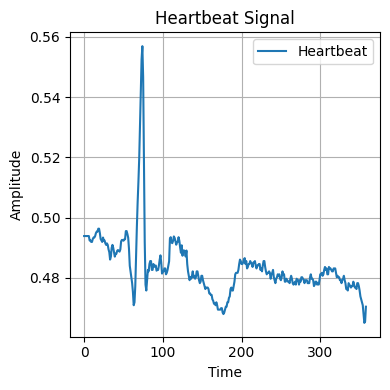

In [11]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_x.iloc[1,1:]

time_axis = np.arange(0, 359)

# Plotting the heartbeat
plt.figure(figsize=(4, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
import pywt

def madev(d, axis=None):
    'Mean absolute deviation of a signal'
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def wavelet_denoising(x, wavelet='sym4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode='per')


df_x = wavelet_denoising(df_x, wavelet='sym4', level=2)
df_x = pd.DataFrame(df_x)


In [13]:
df_y = pd.DataFrame(Y, columns=['ColumnName'])
print(df_y)

       ColumnName
0               N
1               N
2               N
3               N
4               N
...           ...
218983          N
218984          N
218985          N
218986          N
218987          N

[218988 rows x 1 columns]


In [14]:
value_counts_y = df_y['ColumnName'].value_counts()
print(value_counts_y)

ColumnName
N    181262
Q     16086
V     14472
S      5562
F      1606
Name: count, dtype: int64


In [15]:
df_fusionné = pd.concat([df_y, df_x], axis=1)
df_fusionné

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
0,N,0.462684,0.482563,0.484096,0.480532,0.482998,0.486249,0.486395,0.485685,0.486417,...,0.465020,0.465024,0.464819,0.464398,0.465694,0.466896,0.465382,0.464333,0.457116,0.448866
1,N,0.482760,0.483433,0.483912,0.484193,0.485481,0.487048,0.488593,0.490109,0.491212,...,0.478506,0.480579,0.478319,0.474973,0.470233,0.465748,0.467314,0.471010,0.475798,0.480966
2,N,0.467232,0.467470,0.467739,0.468055,0.468426,0.468822,0.469268,0.469721,0.470049,...,0.468349,0.468087,0.467870,0.467685,0.467553,0.467453,0.467324,0.467222,0.467132,0.467090
3,N,0.479895,0.479832,0.479771,0.479715,0.479675,0.479642,0.479619,0.479602,0.479579,...,0.480596,0.480528,0.480454,0.480378,0.480302,0.480226,0.480155,0.480086,0.480021,0.479959
4,N,0.464471,0.464553,0.464697,0.464878,0.465010,0.465157,0.465309,0.465495,0.465847,...,0.466040,0.465762,0.465515,0.465292,0.465104,0.464941,0.464782,0.464649,0.464529,0.464447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218983,N,0.502549,0.503219,0.503970,0.504905,0.506167,0.507510,0.509082,0.510603,0.511255,...,0.503049,0.512831,0.513578,0.511194,0.508427,0.505098,0.503870,0.503402,0.502718,0.502278
218984,N,0.481103,0.482376,0.483396,0.484397,0.485813,0.487135,0.488612,0.489774,0.489091,...,0.473678,0.474432,0.475248,0.476068,0.476994,0.477916,0.478539,0.479103,0.479571,0.480058
218985,N,0.500133,0.501232,0.502311,0.503425,0.504636,0.505821,0.507070,0.508225,0.508845,...,0.495166,0.495084,0.495333,0.495740,0.496284,0.496916,0.497438,0.497986,0.498551,0.499183
218986,N,0.473481,0.472011,0.471962,0.472347,0.470815,0.469819,0.469559,0.471079,0.479538,...,0.474385,0.475119,0.474671,0.473870,0.472596,0.471306,0.471491,0.472085,0.473125,0.474271


In [16]:
line = df_fusionné.loc[df_fusionné['ColumnName'] == 'F']
line

,ColumnName,0,1,2,3,4,5,6,7,8,...,350,351,352,353,354,355,356,357,358,359
35688,F,0.470791,0.471129,0.471506,0.471935,0.472422,0.472933,0.473492,0.474049,0.474472,...,0.472640,0.471741,0.471226,0.470905,0.470712,0.470626,0.470516,0.470459,0.470467,0.470549
35689,F,0.546729,0.542418,0.546707,0.532105,0.535295,0.539866,0.537283,0.532356,0.529307,...,0.449714,0.454053,0.452546,0.449023,0.452061,0.457939,0.452790,0.451805,0.457584,0.451342
36800,F,0.457448,0.456692,0.451720,0.460315,0.457170,0.453170,0.454642,0.457557,0.456950,...,0.521591,0.518271,0.520944,0.524715,0.528722,0.532006,0.526035,0.512482,0.512692,0.526064
36801,F,0.561165,0.558885,0.567761,0.561766,0.563610,0.564882,0.559502,0.552604,0.553470,...,0.489085,0.492321,0.489051,0.483733,0.483447,0.485631,0.481121,0.481045,0.486114,0.481869
38328,F,0.440255,0.436968,0.432605,0.429003,0.430689,0.434238,0.439245,0.444523,0.445407,...,0.458410,0.455581,0.456249,0.457735,0.460308,0.462638,0.459693,0.454772,0.449776,0.444487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210255,F,0.554965,0.557088,0.563495,0.559636,0.562206,0.564605,0.562495,0.559181,0.559999,...,0.508593,0.511565,0.509718,0.506830,0.504064,0.501750,0.505500,0.514881,0.513137,0.501462
210556,F,0.515738,0.515866,0.515964,0.516059,0.516164,0.516257,0.516365,0.516461,0.516439,...,0.512161,0.513599,0.514391,0.514869,0.515222,0.515429,0.515592,0.515701,0.515695,0.515649
210557,F,0.517746,0.513471,0.508094,0.503071,0.502508,0.503678,0.505732,0.508274,0.509055,...,0.515519,0.512564,0.515109,0.519281,0.524482,0.529569,0.529415,0.527028,0.524789,0.521865
212980,F,0.444410,0.445850,0.448225,0.451440,0.452732,0.453622,0.454850,0.456216,0.458210,...,0.468654,0.458499,0.454522,0.454822,0.464965,0.477416,0.473523,0.464830,0.455413,0.445958


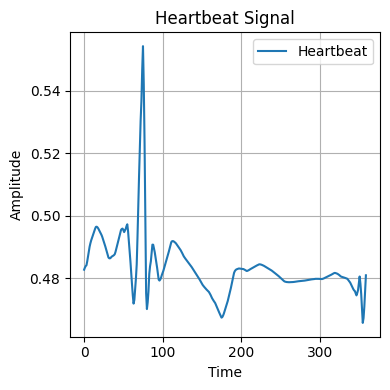

In [19]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[1,1:]

time_axis = np.arange(0, 360)

# Plotting the heartbeat
plt.figure(figsize=(4, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

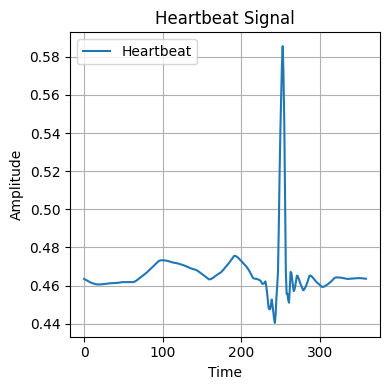

In [23]:
import matplotlib.pyplot as plt
import numpy as np

heartbeat_values = df_fusionné.iloc[6,1:]
heartbeat_values
# Creating a time axis for the 3600 points, assuming each point represents a unit of time
time_axis = np.arange(0, 360)

# Plotting the heartbeat
plt.figure(figsize=(4, 4))
plt.plot(time_axis, heartbeat_values, label='Heartbeat')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Heartbeat Signal')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()